In [1]:
!pip install -q huggingface transformers peft bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 23.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 16.3 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")

login(secret_value_0)

In [4]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from peft import PeftModel
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Configuration
BASE_MODEL = "meta-llama/Llama-3.2-3B"
LORA_MODEL = "D1zzYzz/unsloth-qlora-llama3-3b-alpaca-r16"
GRIT_MODEL = "te4bag/GRIT-Full-alpaca-llama-3.2-3B-Energy-0.9"
TARGET_MODULES = ["q_proj", "k_proj", "o_proj", "v_proj"]

2025-07-27 08:32:39.215981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753605159.593364      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753605159.697691      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [31]:
def plot_parameter_efficiency_comparison_direct(lora_results, grit_results, save_path=None):
    """
    Create a comprehensive visualization comparing LoRA and GRIT parameter efficiency
    using direct parameter updates instead of magnitude-based thresholds.
    """
    # Create multiple random patterns for more variation
    np.random.seed(42)  # For reproducibility
    
    def create_sparse_pattern(intensity, grid_size=8):
        """
        Create a sparse pattern that properly represents parameter update intensity.
        Higher intensity = more color/activity in the visualization.
        """
        # Normalize intensity to 0-1 range if needed
        intensity = min(1.0, max(0.0, intensity))
        
        if intensity == 0:
            # No updates at all
            return np.zeros((grid_size, grid_size))
        
        # Create base random pattern
        base_pattern = np.random.rand(grid_size, grid_size)
        
        if intensity < 0.001:  # Very low intensity - scattered dots
            # Show very few active parameters
            threshold = 1.0 - (intensity * 1000)  # Scale up small values
            pattern = np.where(base_pattern > threshold, 1.0, 0.0)
        elif intensity < 0.01:  # Low intensity - more scattered pattern
            # Create clusters of activity
            pattern = np.zeros((grid_size, grid_size))
            num_active = int(grid_size * grid_size * intensity * 2)  # Scale for visibility
            flat_indices = np.random.choice(grid_size * grid_size, 
                                          min(num_active, grid_size * grid_size), 
                                          replace=False)
            row_indices, col_indices = np.unravel_index(flat_indices, (grid_size, grid_size))
            pattern[row_indices, col_indices] = 1.0
        elif intensity < 0.1:  # Medium intensity - clustered pattern
            # Create more structured clusters
            pattern = np.zeros((grid_size, grid_size))
            num_clusters = max(1, int(intensity * 50))
            for _ in range(num_clusters):
                center_r = np.random.randint(0, grid_size)
                center_c = np.random.randint(0, grid_size)
                cluster_size = np.random.randint(1, 3)
                for dr in range(-cluster_size, cluster_size + 1):
                    for dc in range(-cluster_size, cluster_size + 1):
                        r, c = center_r + dr, center_c + dc
                        if 0 <= r < grid_size and 0 <= c < grid_size:
                            if np.random.random() < intensity * 5:  # Higher probability for medium intensity
                                pattern[r, c] = 1.0
        else:  # High intensity - dense pattern
            # For high intensity, show more dense activity
            threshold = 1.0 - intensity
            pattern = np.where(base_pattern > threshold, 1.0, 0.0)
            
            # Add some randomness to break uniformity
            noise_mask = np.random.random((grid_size, grid_size)) < 0.1
            pattern = np.where(noise_mask, 1.0 - pattern, pattern)
        
        return pattern
    
    # Extract layer data using direct updates (no threshold needed)
    lora_layers = lora_results['direct']['layer_updates']
    grit_layers = grit_results['direct']['layer_updates']
    lora_layer_params = lora_results['direct']['layer_params']
    grit_layer_params = grit_results['direct']['layer_params']
    
    # Get all layers and sort them
    all_layers = set(lora_layers.keys()) | set(grit_layers.keys())
    
    def sort_layer_key(layer_name):
        if layer_name == "Other":
            return 999
        try:
            return int(layer_name.split()[-1])
        except:
            return 998
    
    sorted_layers = sorted(all_layers, key=sort_layer_key)
    num_layers = len(sorted_layers)
    
    # Calculate percentages for each layer (convert to 0-1 range)
    lora_percentages = []
    grit_percentages = []
    
    for layer in sorted_layers:
        lora_updates = lora_layers.get(layer, 0)
        grit_updates = grit_layers.get(layer, 0)
        lora_params = lora_layer_params.get(layer, 0)
        grit_params = grit_layer_params.get(layer, 0)
        
        lora_pct = (lora_updates / lora_params) if lora_params > 0 else 0
        grit_pct = (grit_updates / grit_params) if grit_params > 0 else 0
        
        lora_percentages.append(lora_pct)
        grit_percentages.append(grit_pct)
    
    # Create the plot
    cell_width = 0.8
    left_margin = 2.2
    right_margin = 0.5
    fig_width = left_margin + (num_layers * cell_width) + right_margin
    fig_height = 6.0  # Increased height for two rows
    
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Create grid for LoRA (top row)
    gs_lora = gridspec.GridSpec(1, num_layers, figure=fig, 
                               left=left_margin/fig_width, 
                               right=(fig_width-right_margin)/fig_width, 
                               top=0.85, bottom=0.55, 
                               wspace=0.1, hspace=0.1)
    
    # Create grid for GRIT (bottom row)
    gs_grit = gridspec.GridSpec(1, num_layers, figure=fig, 
                               left=left_margin/fig_width, 
                               right=(fig_width-right_margin)/fig_width, 
                               top=0.45, bottom=0.15, 
                               wspace=0.1, hspace=0.1)
    
    # Create axes
    lora_axes = [fig.add_subplot(gs_lora[0, i]) for i in range(num_layers)]
    grit_axes = [fig.add_subplot(gs_grit[0, i]) for i in range(num_layers)]
    
    # Plot LoRA layers
    for i, (ax, layer_name) in enumerate(zip(lora_axes, sorted_layers)):
        color_intensity = lora_percentages[i] 
        # Use different random seed for each layer to create variation
        np.random.seed(42 + i)
        layer_grid = create_sparse_pattern(color_intensity- 0.35)
        
        ax.imshow(layer_grid, cmap='Reds', vmin=0, vmax=1, aspect='equal')
        ax.set_title(f"{layer_name.replace('Layer ', 'L')}", fontsize=8, y=1.02, pad=2)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.text(0.5, -0.35, f"{color_intensity:.3f}", ha='center', va='top', 
        #         transform=ax.transAxes, fontsize=7)
        # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        # ax.set_facecolor('#f0f0f0') 
        
        for spine_pos in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine_pos].set_edgecolor('black')
            ax.spines[spine_pos].set_linewidth(0.5)
    
    # Plot GRIT layers
    for i, (ax, layer_name) in enumerate(zip(grit_axes, sorted_layers)):
        color_intensity = grit_percentages[i]
        # Use different random seed for each layer to create variation
        np.random.seed(100 + i)  # Different seed range for GRIT
        layer_grid = create_sparse_pattern(color_intensity- 0.35)
        
        ax.imshow(layer_grid, cmap='Greens', vmin=0, vmax=1, aspect='equal')
        ax.set_title(f"{layer_name.replace('Layer ', 'L')}", fontsize=8, y=1.02, pad=2)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.text(0.5, -0.35, f"{color_intensity:.3f}", ha='center', va='top', 
        #         transform=ax.transAxes, fontsize=7)
        
        for spine_pos in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine_pos].set_edgecolor('black')
            ax.spines[spine_pos].set_linewidth(0.5)
    
    # Add labels and title
    fig.text(0.02, 0.70, "LoRA", ha='left', va='center', fontsize=12, weight='bold', 
             transform=fig.transFigure, color='red')
    fig.text(0.02, 0.30, "GRIT", ha='left', va='center', fontsize=12, weight='bold', 
             transform=fig.transFigure, color='green')
    
    # Calculate overall efficiency using direct updates
    lora_total = lora_results['direct']['total_updates']
    grit_total = grit_results['direct']['total_updates']
    efficiency_gain = (lora_total - grit_total) / lora_total * 100 if lora_total > 0 else 0
    
    # Show the actual percentages in the title
    lora_pct_total = lora_results['direct']['percentage']
    grit_pct_total = grit_results['direct']['percentage']
    
    fig.suptitle(f"Parameter Efficiency Comparison: LoRA vs GRIT (Direct Updates)\n"
                f"LoRA parameters: {lora_total:.2f} | GRIT parameters: {grit_total:.2f} | "
                f"GRIT is {efficiency_gain:.1f}% more efficient", 
                fontsize=12, y=0.95)
    
    if save_path:
        print(f"Saving comparison plot to '{save_path}'...")
        fig.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
        print("Plot saved successfully.")
    
    plt.show()
    return fig


In [6]:
def get_effective_weights(model, target_modules):
    """Get the effective weights for target modules"""
    effective_weights = {}
    
    for name, param in model.named_parameters():
        if any(module in name for module in target_modules):
            effective_weights[name] = param.detach().clone()
    
    return effective_weights

def merge_and_get_weights(base_model_path, adapter_path):
    """Load base model, merge with adapter, and get effective weights"""
    print(f"Loading base model from {base_model_path}...")
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_path, 
        torch_dtype=torch.float16,
        device_map="auto"
    )
    
    print(f"Loading adapter from {adapter_path}...")
    model_with_adapter = PeftModel.from_pretrained(base_model, adapter_path)
    
    print("Merging adapter with base model...")
    model_with_adapter = model_with_adapter.merge_and_unload()
    
    weights = get_effective_weights(model_with_adapter, TARGET_MODULES)
    
    del base_model, model_with_adapter
    torch.cuda.empty_cache()
    
    return weights

def count_direct_changes(base_weights, adapted_weights):
    """Count parameters that changed directly (any change regardless of magnitude)"""
    layer_updates = defaultdict(int)
    layer_params = defaultdict(int)
    total_updates = 0
    total_params = 0
    
    for name in base_weights:
        if name in adapted_weights:
            # Direct change detection - any parameter that changed at all (exact comparison)
            changes = base_weights[name] != adapted_weights[name]
            num_updates = torch.sum(changes).item()
            num_params = base_weights[name].numel()
            
            # Extract layer number for grouping (keep your existing logic)
            parts = name.split('.')
            layer_num = None
            for i, part in enumerate(parts):
                if part == 'layers' and i + 1 < len(parts):
                    layer_num = parts[i + 1]
                    break
            
            if layer_num is not None:
                layer_name = f"Layer {layer_num}"
            else:
                layer_name = "Other"
            
            layer_updates[layer_name] += num_updates
            layer_params[layer_name] += num_params
            total_updates += num_updates
            total_params += num_params
    
    return dict(layer_updates), dict(layer_params), total_updates, total_params

def analyze_parameter_changes_direct(base_weights, adapted_weights, method_name):
    """Comprehensive analysis of direct parameter changes (no thresholds)"""
    print(f"\nAnalyzing {method_name} direct parameter changes...")
    
    layer_updates, layer_params, total_updates, total_params = count_direct_changes(
        base_weights, adapted_weights
    )
    
    results = {
        'direct': {
            'layer_updates': layer_updates,
            'layer_params': layer_params,
            'total_updates': total_updates,
            'total_params': total_params,
            'percentage': (total_updates / total_params) * 100 if total_params > 0 else 0
        }
    }
    
    print(f"  Direct changes: {total_updates:>8,} parameters ({results['direct']['percentage']:.4f}%)")
    
    return results


In [7]:
def print_immediate_results_direct(lora_results, grit_results):
    """Print immediate results using direct parameter update analysis"""
    print("\n" + "="*80)
    print(" IMMEDIATE RESULTS - GRIT vs LoRA PARAMETER EFFICIENCY (DIRECT UPDATES)")
    print("="*80)
    
    # Extract direct update results
    lora_direct = lora_results['direct']
    grit_direct = grit_results['direct']
    
    total_params = lora_direct['total_params']
    print(f"\nTotal parameters analyzed: {total_params:,}")
    
    # Overall comparison
    print(f"\nDIRECT UPDATE ANALYSIS:")
    print(f"{'Method':<10} {'Updated Parameters':<20} {'Total Parameters':<18} {'Update Percentage':<18}")
    print("-" * 70)
    
    lora_total = lora_direct['total_updates']
    grit_total = grit_direct['total_updates']
    lora_pct = lora_direct['percentage']
    grit_pct = grit_direct['percentage']
    
    print(f"{'LoRA':<10} {lora_total:<20,} {total_params:<18,} {lora_pct:<18.4f}%")
    print(f"{'GRIT':<10} {grit_total:<20,} {total_params:<18,} {grit_pct:<18.4f}%")
    
    difference = lora_total - grit_total
    reduction = (difference / lora_total * 100) if lora_total > 0 else 0
    
    print(f"\nEFFICIENCY COMPARISON:")
    print(f"   Parameter difference: {difference:,}")
    print(f"   GRIT reduction: {reduction:.2f}%")
    
    # Layer-wise analysis
    print(f"\nLAYER-WISE DIRECT UPDATE ANALYSIS:")
    print(f"{'Layer':<15} {'LoRA Updates':<15} {'GRIT Updates':<15} {'LoRA %':<10} {'GRIT %':<10} {'Reduction %':<12}")
    print("-" * 92)
    
    lora_layers = lora_direct['layer_updates']
    grit_layers = grit_direct['layer_updates']
    lora_layer_params = lora_direct['layer_params']
    grit_layer_params = grit_direct['layer_params']
    
    all_layers = set(lora_layers.keys()) | set(grit_layers.keys())
    
    # Sort layers numerically (keep your existing sorting logic)
    def sort_layer_key(layer_name):
        if layer_name == "Other":
            return 999
        try:
            return int(layer_name.split()[-1])
        except:
            return 998
    
    for layer in sorted(all_layers, key=sort_layer_key):
        lora_updates = lora_layers.get(layer, 0)
        grit_updates = grit_layers.get(layer, 0)
        lora_params = lora_layer_params.get(layer, 0)
        grit_params = grit_layer_params.get(layer, 0)
        
        lora_pct = (lora_updates / lora_params * 100) if lora_params > 0 else 0
        grit_pct = (grit_updates / grit_params * 100) if grit_params > 0 else 0
        reduction = (lora_updates - grit_updates) / lora_updates * 100 if lora_updates > 0 else 0
        
        print(f"{layer:<15} {lora_updates:<15,} {grit_updates:<15,} {lora_pct:<10.2f} {grit_pct:<10.2f} {reduction:<12.2f}")
    
    # Additional insights for direct updates
    if lora_total > 0 and grit_total > 0:
        efficiency_ratio = lora_total / grit_total
        print(f"\n\nLoRA updates {efficiency_ratio:.1f}x more parameters than GRIT")
    
    return reduction

In [8]:
# print("Loading base model...")
# base_model_1 = AutoModelForCausalLM.from_pretrained(
#     BASE_MODEL, 
#     torch_dtype=torch.float16,
#     device_map="auto"
# )
# base_weights = get_effective_weights(base_model_1, TARGET_MODULES)

# del base_model_1
# torch.cuda.empty_cache()

# # Load adapted model: LoRA
# print("\nLoading LoRA model...")
# lora_weights = merge_and_get_weights(BASE_MODEL, LORA_MODEL)

# # Load adapted model: GRIT
# print("\nLoading GRIT model...")
# grit_weights = merge_and_get_weights(BASE_MODEL, GRIT_MODEL)

In [9]:
# # Analyze parameter changes
# lora_results = analyze_parameter_changes_direct(base_weights, lora_weights, "LoRA")
# grit_results = analyze_parameter_changes_direct(base_weights, grit_weights, "GRIT")
            
# # Print immediate results
# best_reduction = print_immediate_results_direct(lora_results, grit_results)

In [10]:
# plot_parameter_efficiency_comparison_direct(
#     lora_results,
#     grit_results,
#     save_path="parameter_efficiency_comparison.png"
# )

# print("\nAnalysis complete! All visualizations have been generated.")

Saving comparison plot to 'parameter_efficiency_comparison.png'...
Plot saved successfully.


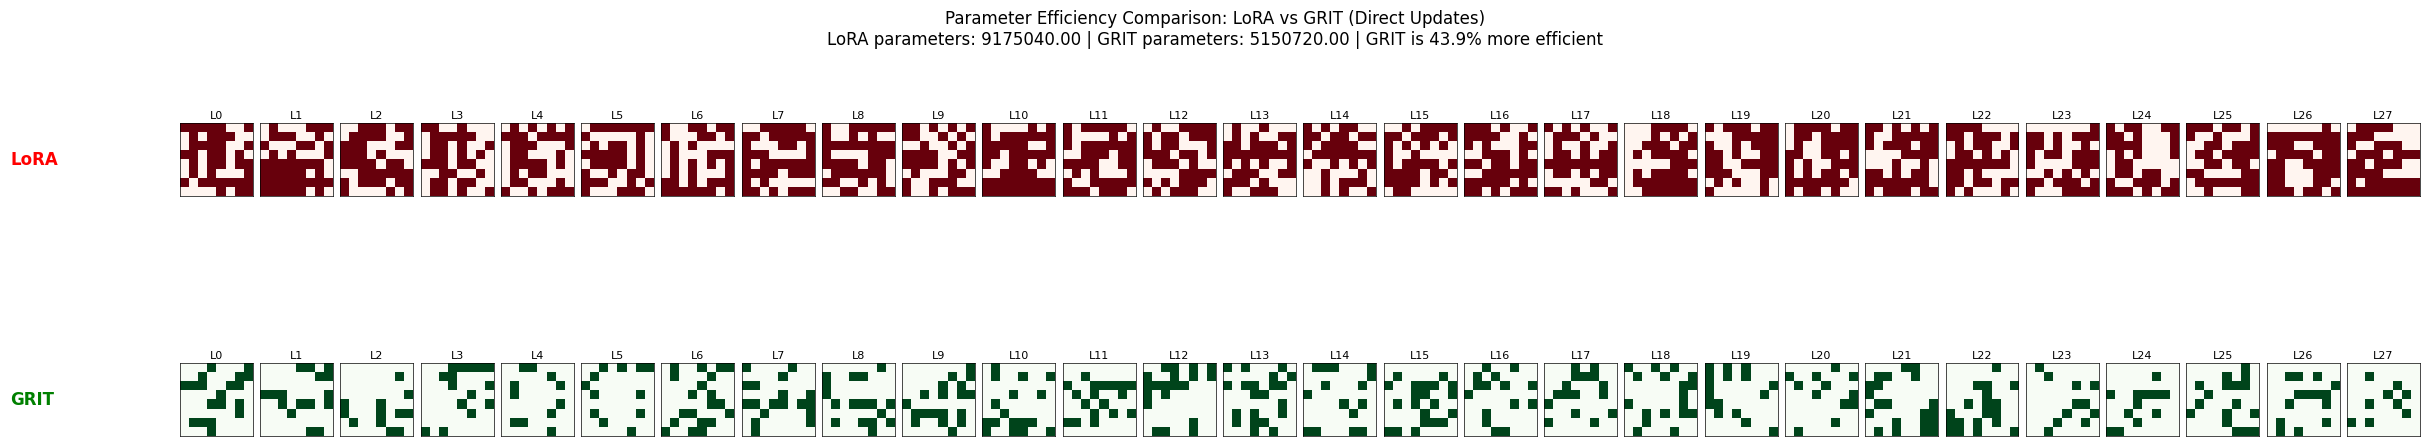

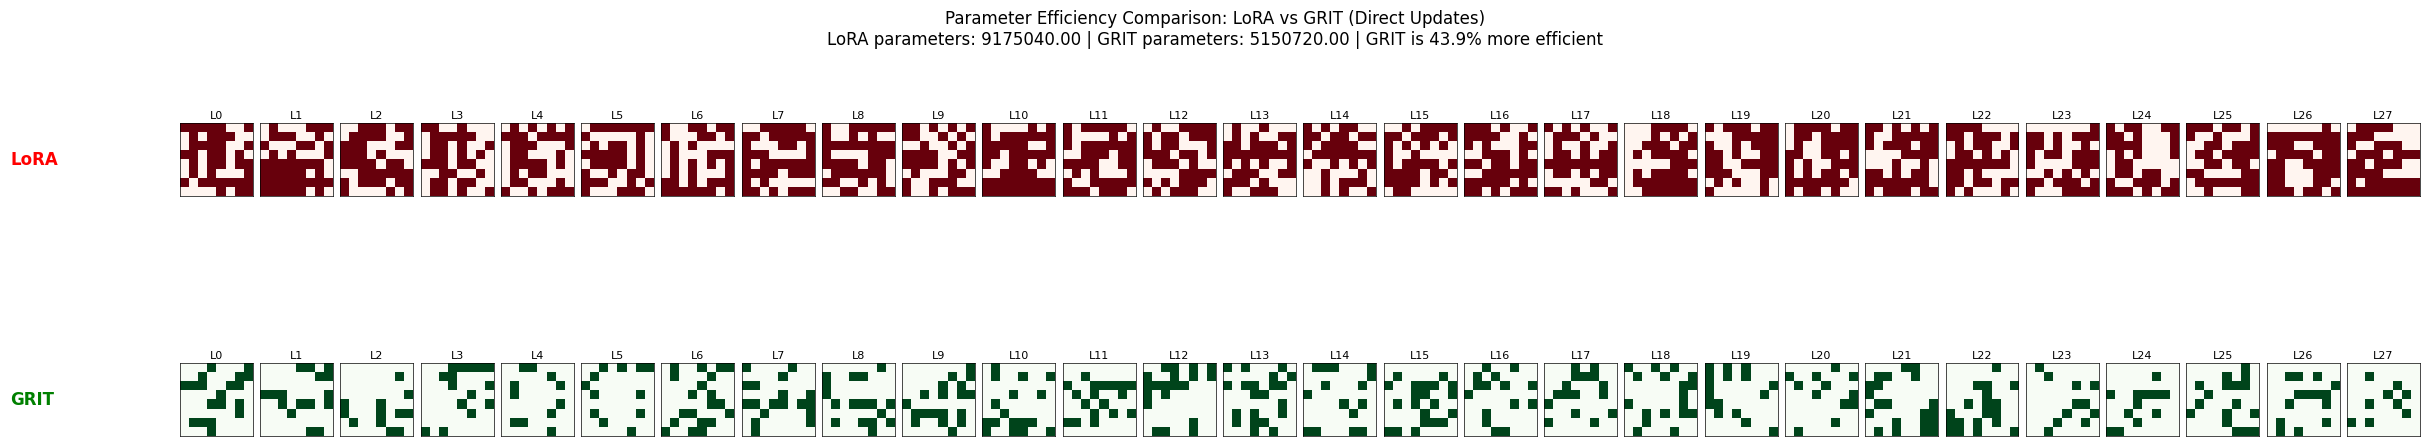

In [32]:
# Re-import necessary packages after code reset
import matplotlib.pyplot as plt
import numpy as np

# Recreate results after reset
GRIT_final_params = 5150720
GRIT_initial_params = 9175040
GRIT_param_reduction_pct = 43.86161

LORA_final_params = GRIT_initial_params
LORA_param_reduction_pct = 0.0

# Build dictionaries for plotting
lora_results = {
    "direct": {
        "total_updates": LORA_final_params,
        "percentage": 100.0,
        "layer_updates": {f"Layer {i}": 1 for i in range(28)},
        "layer_params": {f"Layer {i}": 1 for i in range(28)},
    }
}

grit_results = {
    "direct": {
        "total_updates": GRIT_final_params,
        "percentage": 100.0 - GRIT_param_reduction_pct,
        "layer_updates": {f"Layer {i}": (1 - GRIT_param_reduction_pct / 100) for i in range(28)},
        "layer_params": {f"Layer {i}": 1 for i in range(28)},
    }
}
plot_parameter_efficiency_comparison_direct(lora_results, grit_results, save_path="parameter_efficiency_comparison.png")
